In [11]:
# %%
import os
os.environ["XDG_CACHE_HOME"] = "/scratch/dengm/distent/pip_cache"
os.environ['PIP_CACHE_DIR'] = "/scratch/dengm/distent/pip_cache"
import sys
sys.path.append('/scratch/dengm/distent/Disentangle-features/archive')
from features import *
from metrics import *
import os
import torch as t
import torch.nn as nn
import pickle
import numpy as np
import torch as t

os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3,6,7"
device = t.device("cuda" if t.cuda.is_available() else "cpu")

model_list = ['roneneldan/TinyStories-1M', 'roneneldan/TinyStories-3M', 'roneneldan/TinyStories-33M', 'EleutherAI/gpt-neo-125M']#, 'EleutherAI/gpt-neo-1.3B']

bert_list = ['prajjwal1/bert-tiny', 'prajjwal1/bert-mini', 'prajjwal1/bert-small', 'prajjwal1/bert-medium']

model_list = model_list + bert_list

last_lamb = 0.1

lamb_var = 0.1


metric_dict = dict()
for name in model_list:
    suffix = name.split('/')[-1]
    print("Model", suffix)
    filename = f"{suffix}_task"
    if lamb_var != 0.1:
        filename = f"lamb{lamb_var}_{filename}"
    f1, e1, inf1 = load_wrapper('svd', filename)
    import matplotlib.pyplot as plt
    print(inf1)
    emb = np.load(f"{suffix}_embs.npy")
    words = np.load(f"{suffix}_words.npy")
    norms = (t.tensor(emb).to(f1.device).norm(dim = 1) ** 2).mean()
    err = (f1 @ e1 - emb).norm(dim = 1) ** 2
    # print(err.sum())
    print("VAR_explained", (norms - err.mean()) / norms)
    # factor = norms / (norms - err.mean())
    factor = 1
    # print("Factor", factor)
    for p in [1]:#[0.7, 0.85, 1]:
        metric_dict[name] = {
            'sparsity' : sparse_metric_mean(p)(f1) * factor, 
            'size': emb.shape[1],
        }
        # print(sparse_metric(p)(f1) * factor)
        print("sparsity", emb.shape[1], sparse_metric_mean(p)(f1) * factor)

Model TinyStories-1M
{'loss': 5797.57177734375, 'loss_est': 3.618266860934431, 'lamb': 0.05654491782188416, 'maxA': 0.5638394, 'guess_factor': 8, 'negative_penalty': 1, 'lr': 0.003, 'steps': 2000, 'size': 50257}
VAR_explained tensor(0.9750)


sparsity 64 tensor(3.1276)
Model TinyStories-3M
{'loss': 8623.869140625, 'loss_est': 5.900503369420343, 'lamb': 0.05654491782188416, 'maxA': 0.5143076, 'guess_factor': 8, 'negative_penalty': 1, 'lr': 0.003, 'steps': 2000, 'size': 50257}
VAR_explained tensor(0.9554)
sparsity 128 tensor(4.8161)
Model TinyStories-33M
{'loss': 16732.357421875, 'loss_est': 21.16908169847552, 'lamb': 0.04002704620361328, 'maxA': 0.3929208, 'guess_factor': 8, 'negative_penalty': 1, 'lr': 0.003, 'steps': 2000, 'size': 50257}
VAR_explained tensor(0.9027)
sparsity 768 tensor(14.8227)
Model gpt-neo-125M
{'loss': 920001.4375, 'loss_est': 1.6035494625866258, 'lamb': 1.0810521125793457, 'maxA': 10.559977, 'guess_factor': 8, 'negative_penalty': 1, 'lr': 0.003, 'steps': 2000, 'size': 50257}
VAR_explained tensor(0.9627)
sparsity 768 tensor(1.1596)
Model bert-tiny
{'loss': 2819.01318359375, 'loss_est': 7.509787905713472, 'lamb': 0.03255292773246765, 'maxA': 0.37780386, 'guess_factor': 8, 'negative_penalty': 1, 'lr': 0.0

Model:  roneneldan/TinyStories-1M Sparsity: 3.1276254653930664 Embedding size: 64
Model:  roneneldan/TinyStories-3M Sparsity: 4.816124439239502 Embedding size: 128
Model:  roneneldan/TinyStories-33M Sparsity: 14.82271957397461 Embedding size: 768


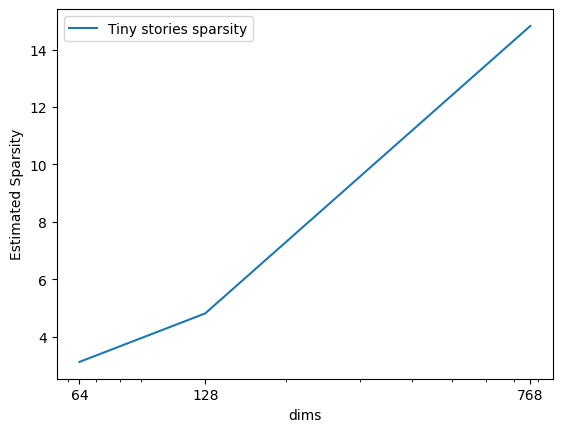

In [28]:

ts = ['roneneldan/TinyStories-1M', 'roneneldan/TinyStories-3M', 'roneneldan/TinyStories-33M']

results = []
for name in ts:
    sparsity = metric_dict[name]['sparsity']
    sz = metric_dict[name]['size']
    # sz = float(name.split('-')[-1].split('M')[0])
    results.append((sz, sparsity))
    print("Model: ", name, "Sparsity:", sparsity.item(),"Embedding size:", sz)
results.sort()
plt.xscale("log")
# plt.xlabel("size (M)")
plt.xlabel("dims")
plt.ylabel("Estimated Sparsity")
plt.xticks([x[0] for x in results], [x[0] for x in results])
plt.plot([x[0] for x in results], [x[1] for x in results], label = "Tiny stories sparsity")
plt.legend()
plt.savefig("sparsity_ts.png")


Model:  prajjwal1/bert-tiny Sparsity: 6.073767185211182 Embedding size: 128
Model:  prajjwal1/bert-mini Sparsity: 9.368404388427734 Embedding size: 256
Model:  prajjwal1/bert-small Sparsity: 11.038105964660645 Embedding size: 512
Model:  prajjwal1/bert-medium Sparsity: 12.535760879516602 Embedding size: 512


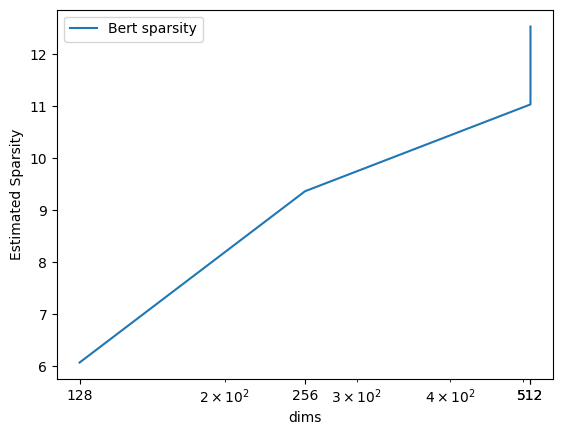

In [29]:

bt = ['prajjwal1/bert-tiny', 'prajjwal1/bert-mini', 'prajjwal1/bert-small', 'prajjwal1/bert-medium']

results = []
for name in bt:
    sparsity = metric_dict[name]['sparsity']
    sz = metric_dict[name]['size']
    # sz = float(name.split('-')[-1].split('M')[0])
    results.append((sz, sparsity))
    print("Model: ", name, "Sparsity:", sparsity.item(),"Embedding size:", sz)
results.sort()
plt.xscale("log")
# plt.xlabel("size (M)")
plt.xlabel("dims")
plt.ylabel("Estimated Sparsity")
plt.xticks([x[0] for x in results], [x[0] for x in results])
plt.plot([x[0] for x in results], [x[1] for x in results], label = "Bert sparsity")
plt.legend()
plt.savefig("sparsity_bt.png")


Model:  EleutherAI/gpt-neo-125M Sparsity: 1.1595818996429443 Embedding size: 768


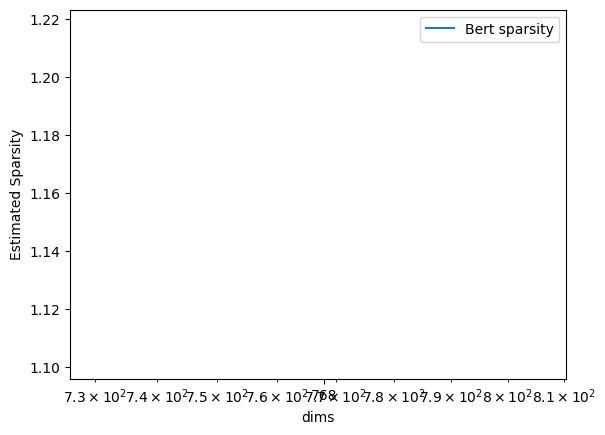

In [30]:
neo = ['EleutherAI/gpt-neo-125M']
results = []
for name in neo:
    sparsity = metric_dict[name]['sparsity']
    sz = metric_dict[name]['size']
    # sz = float(name.split('-')[-1].split('M')[0])
    results.append((sz, sparsity))
    print("Model: ", name, "Sparsity:", sparsity.item(),"Embedding size:", sz)
# results.sort()
# plt.xscale("log")
# # plt.xlabel("size (M)")
# plt.xlabel("dims")
# plt.ylabel("Estimated Sparsity")
# plt.xticks([x[0] for x in results], [x[0] for x in results])
# plt.plot([x[0] for x in results], [x[1] for x in results], label = "Bert sparsity")
# plt.legend()
# plt.savefig("sparsity_bt.png")
